# Using two histograms to bin in space and time
Here we use two histograms to bin in space and time.
We simulate an area detector measuring an isotropic diffraction pattern varying as 1/R.
We use the histogram to bin counts over regions of similar R.

In [1]:
# Import libraries
import time as ttime
import numpy as np
from matplotlib import pyplot as plt

%matplotlib notebook

from skbeam.core.accumulators.histogram import Histogram

In [2]:
# define functions
def plcircle(ax, xy0,r,color=None):
    '''plot circle
        xy0 : tuple of x0, y0
        r : radius
    '''
    phi = np.linspace(0.,2*np.pi,100)
    x0, y0 = xy0
    ax.plot(x0 + np.cos(phi)*r, y0 + np.sin(phi)*r,color=color)

# Image generator
def gen(N,Nx,Ny,mu0):
    ''' Generate a sequence of images mu0/R.'''
    x = np.arange(-Nx//2,Nx//2+1)
    y = np.arange(-Ny//2,Ny//2+1)
    X, Y = np.meshgrid(x,y)
    R = np.maximum(np.sqrt(X**2 + Y**2),1)
    #mu = mu0*np.ones_like(R)
    mu = mu0/R
    for i in range(N):
        yield np.random.poisson(mu).astype(float)

In [3]:
# Initialize parameters
# Number of pixels in x
Nx = 1000
# Number of pixels in y
Ny = 1000
# Number of times for image generator
Nt = 10

# Average count rate at center
mu0 = 1e4 


# coordinates
x = np.arange(-Nx//2,Nx//2+1)
y = np.arange(-Ny//2,Ny//2+1)
X, Y = np.meshgrid(x,y)
R = np.maximum(np.sqrt(X**2 + Y**2),1)
# The bins to histogram in space
bins = R.ravel().astype(int)

<IPython.core.display.Javascript object>


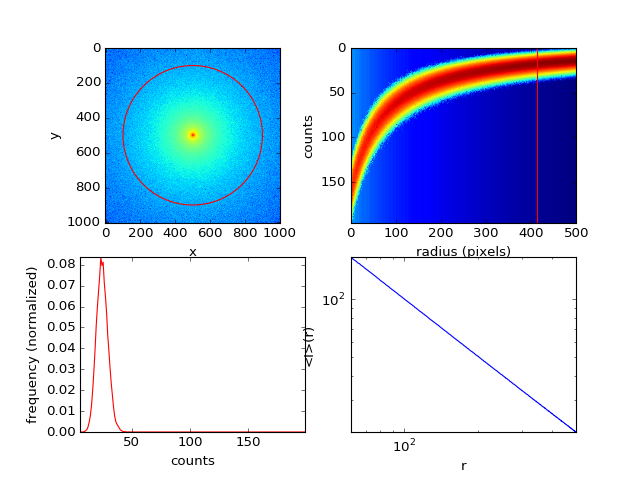

In [4]:
# Initialize the histogram object
h = Histogram((196,5,200),(500,60,500))

# this array is just here to keep track of number of counts per ring
htot = Histogram((1,0,1.1),(500,60,500))

onesarr = np.ones_like(R.ravel()).astype(float)

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2)

In [5]:
for i,img in enumerate(gen(Nt,Nx,Ny,mu0)):
    # count
    h.fill(img.ravel(),R.ravel())
    # keep track of counts per ring
    htot.fill(onesarr,R.ravel())

    # plot log of image
    ax0.cla()
    ax0.imshow(np.log10(np.maximum(img,1)))
    ax0.set_aspect('equal')
    plcircle(ax0, (Nx//2,Ny//2), 400,color='r')
    ax0.autoscale_view('tight')
    ax0.set_xlabel("x")
    ax0.set_ylabel("y")

    # plot the 2D histogram
    ax1.cla();
    w = np.where(htot.values[0] > 0)
    ax1.imshow(np.log(np.maximum(h.values,1)/htot.values[0]))
    ax1.set_aspect('auto')
    ax1.axvline(h.centers[1][400],color='r')
    ax1.set_ylabel("counts")
    ax1.set_xlabel("radius (pixels)")

    # plot the histogram at the row shown by the vertical line in the previous figure
    ax2.cla();
    #need to divide by number of counts per ring
    ax2.plot(h.centers[0],h.values[:,400]/htot.values[0,400],'r')
    ax2.autoscale_view('tight')
    ax2.set_xlabel("counts")
    ax2.set_ylabel("frequency (normalized)")

    # plot the average intensity versus radius
    ax3.cla();
    ax3.loglog(h.centers[1],np.sum(h.values*(h.centers[0])[:,np.newaxis],axis=0)/htot.values[0])
    ax3.autoscale_view('tight')
    ax3.set_xlabel("r")
    ax3.set_ylabel("<I>(r)")
    
    fig.canvas.draw()
    ttime.sleep(0.01)